In [1]:
import pickle
import os
import time
import numpy as np
import ast

import polychrom

from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import polychrom.contactmaps

import cooltools
import cooltools.lib.plotting

import pandas as pd
import warnings
import h5py 
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import sys

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### making dictionary of trajectories

In [3]:
path_dict = {}

directory = '/project/fudenber_735/polychrom/pds5_wapl_nipbl/layout_with_random_boundary'

for name  in glob.glob(directory+'/simulations/static_boundary_sims/layout_b/LIFETIME*'):
    path_dict[name.split('layout_b/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))

### function for calculating P(s)

In [4]:
resolution = 2500
mapN = 3000
bins = np.array(cooltools.numutils.logbins(2, mapN-5 , N=30)) 
binmids = .5*(bins[:-1]+bins[1:]) *resolution
#print('bins defined at', resolution)
#print(bins, binmids)

def doScaling(bins,heatmap,distmap,mask):
    h = heatmap[mask]; d = distmap[mask]
    inds = np.argsort(d)
    h=h[inds]; d=d[inds]; p = np.zeros(len(bins)-1,)
    binlocs = np.searchsorted(d,bins,'left')
    binnedObs = []; binnedExp = []
    for j in range(len(binlocs)-1):
        binnedObs.append(np.sum(h[binlocs[j]:binlocs[j+1]]))
        binnedExp.append(len(d[binlocs[j]:binlocs[j+1]]))
        if binlocs[j+1]-binlocs[j] != len(d[binlocs[j]:binlocs[j+1]]):   asdf
    binnedObs = np.array(binnedObs)
    binnedExp = np.array(binnedExp)
    return binnedObs, binnedExp

### Saving contact frequency vs distance

In [5]:
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime, separation, rstall, lstall, rstallc, lstallc, stalldist, steps, velocitymultiplier,Tad=params
    data = np.load(directory+'/analysis/maps/layout_b/%s.npz' % name)
    mrc=data['arr_0']
    mrc  = mrc.astype(float)
    mrc /= np.median(np.diag(mrc,2))
    distmap = np.abs (np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
    o, e = doScaling(bins, mrc, distmap, distmap>0)
    #print(binmids,o/e)
    np.savetxt(directory + '/analysis/p_s/ps_for_layout_b/%s.dat'%name, np.c_[binmids,o/e])

### Plot

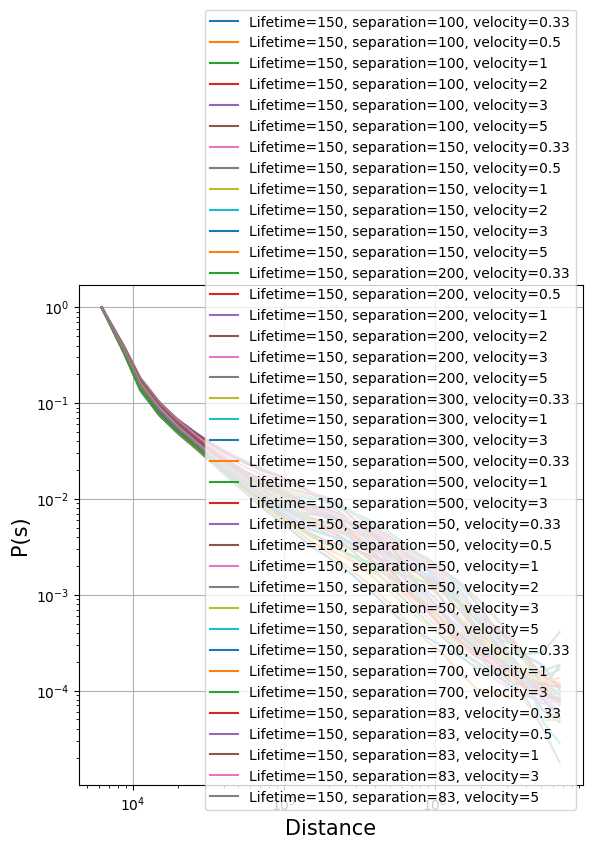

In [6]:
plt.figure(figsize=(6.5, 6.5))
distmap =    np.abs(np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime, separation, rstall, lstall, rstallc, lstallc, stalldist, steps, velocitymultiplier,Tad=params
    data = np.loadtxt(directory + '/analysis/p_s/ps_for_layout_b/%s.dat'%name)
    contact_freq = data[:,1]
    distance = data[:,0]
    if Lifetime==150:
        plt.loglog(distance, contact_freq, label='Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
plt.grid(True)
plt.xlabel('Distance',fontsize = 15)
plt.ylabel('P(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1., .75),loc='right')
plt.show()

### P'(s)

In [7]:
from polychrom.polymer_analyses import slope_contact_scaling

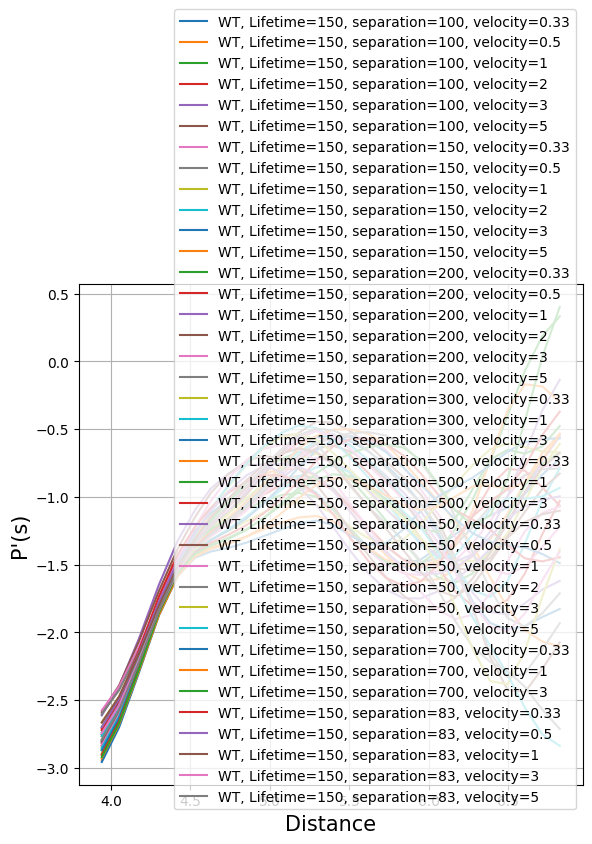

In [8]:
plt.figure(figsize=(6.5, 6.5))
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime, separation, rstall, lstall, rstallc, lstallc, stalldist, steps, velocitymultiplier,Tad=params
    data = np.loadtxt(directory + '/analysis/p_s/ps_for_layout_b/%s.dat'%name)
    contact_freq = data[:,1]
    distance = data[:,0]
    
    s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
    
    if Lifetime == 150:
        plt.plot(np.log10(s), der, label='WT, Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
plt.grid(True)
plt.xlabel('Distance', fontsize = 15)
plt.ylabel('P\'(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1., .75),loc='right')
plt.show()

### P''(s)

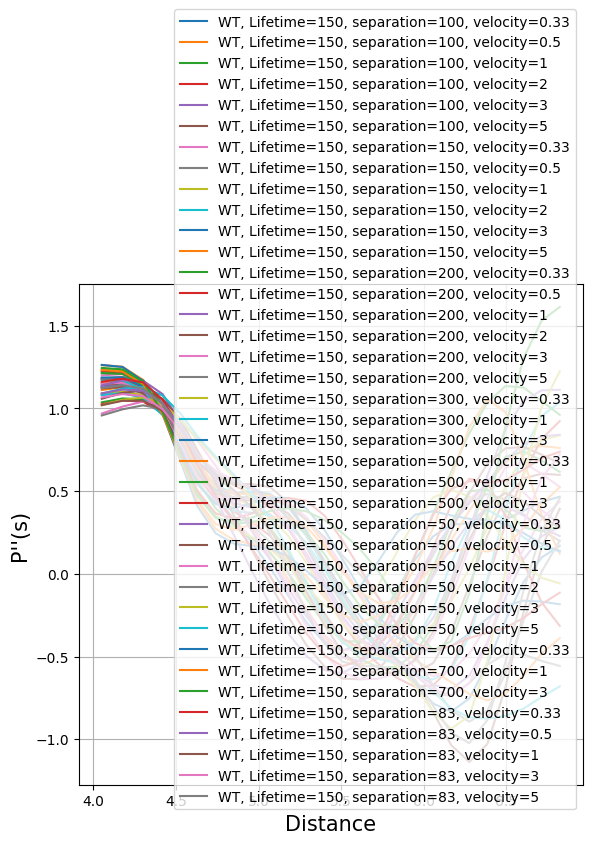

In [9]:
plt.figure(figsize=(6.5, 6.5))
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime, separation, rstall, lstall, rstallc, lstallc, stalldist, steps, velocitymultiplier,Tad=params
    data = np.loadtxt(directory + '/analysis/p_s/ps_for_layout_b/%s.dat'%name)
    contact_freq = data[:,1]
    distance = data[:,0]
    
    s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
    sp,derp=slope_contact_scaling(s,np.exp(der),sigma=1.5)
    if Lifetime == 150:
        plt.plot(np.log10(sp), derp, label='WT, Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
plt.grid(True)
plt.xlabel('Distance', fontsize = 15)
plt.ylabel('P\'\'(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1., .75),loc='right')
plt.show()

### Examples of interest

In [14]:
#print(path_dict.keys())

new_dict = {'LIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000',
         'LIFETIME_150_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_1_Tad_1000',
         'LIFETIME_150_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_3_Tad_1000',
         'LIFETIME_150_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_STEPS_200_velocitymultiplier_0.33_Tad_1000'
         }

NameError: name 'new_dict' is not defined

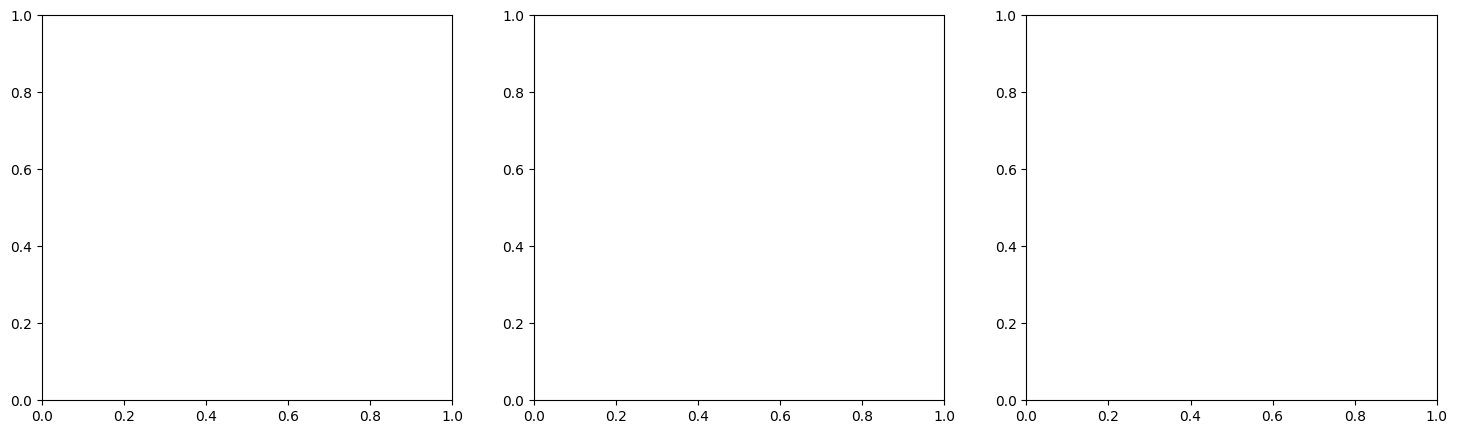

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column
distmap =    np.abs(np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
for name in new_dict:
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime, separation, rstall, lstall, rstallc, lstallc, stalldist, steps, velocitymultiplier,Tad=params
    data = np.loadtxt(directory + '/analysis/p_s/ps_for_layout_b/%s.dat'%name)
    contact_freq = data[:,1]
    distance = data[:,0]
    s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
    sp,derp=slope_contact_scaling(s, np.exp(der),sigma=1.5)
    axs[1].plot(np.log10(s), der, label='WT, Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
    axs[0].loglog(distance, contact_freq, label='Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
    axs[2].plot(np.log10(sp), derp, label='WT, Lifetime=%s, separation=%s, velocity=%s'%(Lifetime,separation, velocitymultiplier))
axs[1].set_ylabel('P\'(s)', fontsize = 15)
axs[2].set_ylabel('P\'\'(s)', fontsize = 15)
axs[0].set_ylabel('P(s)', fontsize = 15)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance', fontsize = 15)
axs[0].legend( bbox_to_anchor=(1.05, 0.87),loc='right')
plt.show()